# Linalgo Annotate SDK demo

In [5]:
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


## Setting up the environment

First we need to import the `linalgo` library to manipulate the tasks created online. The installation is described [here](https://linalgo.github.io/annotate-sdk/).

In [6]:
import os 
from linalgo.client import LinalgoClient

Then let's connect to the backend. 
- We need to know the address of you annotate instance (localhost in this case)
- To get the authentication token, we must connect to the platform and retrieve it from the developper dashboard

In [7]:
token = os.getenv('LIN_TOKEN')
api_url = 'http://localhost:8000'
linalgo_client = LinalgoClient(token=token, api_url=api_url)

We are now ready to list the tasks to which we have access and select the ones we would like to work on.

In [8]:
tasks = linalgo_client.get_tasks([22])
for task in tasks:
    print(f"id: {task.id}, name: {task.name}")

id: 22, name: WRT3 Text 3 Class 3R2 (all)


## Training a machine learning algorithm

Let's look at the different types of annotations that have been made on the tasks we selected.

In [9]:
entities = task.entities
for entity in entities:
    print(f"id: {entity['id']}, name: {entity['title']}")

id: 4, name: CT Ideate
id: 5, name: CT Justify
id: 6, name: CT Validate
id: 7, name: CT Challenge
id: 8, name: CT Clarify
id: 9, name: CT Synthesis
id: 10, name: CT Elaboration


In this study, we're going to train one algorithm per entity type (binary classification). We'll start with the `CT Ideate` type (id 4) and filter the dataset for these annotations only using the `task_transform()` function. 

In [10]:
entity = entities[0]
label = entity['id']
data, target = [], []
for task in tasks:
    docs, labels = task.transform(target='binary',  label=label)
    data.extend(docs)
    target.extend(labels)

In [11]:
print(f"entity: {entity['title']}")
print(f"number of docs: {len(data)}")
print('----------------------------')
print(f"1: 'data': {data[0]}, 'label': {target[0]}")
print(f"2: 'data': {data[1]}, 'label': {target[1]}")
print(f"3: 'data': {data[2]}, 'label': {target[2]}")
print('...')

entity: CT Ideate
number of docs: 107
----------------------------
1: 'data': Being filial in Asian communities is being welcome to their parents instead of rejecting them, 'label': 1
2: 'data': That is a very weak and inaccurate way of stating what is filial piety.It might not even be about accepting your parents.It can be about other things like appreciating famliy traditions and cultures.Just saying that there is only one way of saying what is fillial piety is quite close minded in my opinion. Sincerely, Collin., 'label': 1
3: 'data': What do you mean by 'rejecting them'?, 'label': 0
...


We have 1220 documents and their associated labels for training. We can now use our favorite classifier from scikit-learn and fit it to our data.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=43)

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

text_clf.fit(X_train, y_train)
y_score = text_clf.decision_function(X_test)

/Users/arnaud/anaconda/envs/python3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Evaluating the model

Now that we have a trained algorithm, we would like to know what kind of performance it has on our current dataset. We'll use the [AuROC](http://gim.unmc.edu/dxtests/roc3.htm) metric for that. [Other metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) might alos be appropriate depending on the type of task that we're automating. 

In [14]:
from sklearn.metrics import roc_curve, auc

In [15]:
fpr, tpr, thres = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

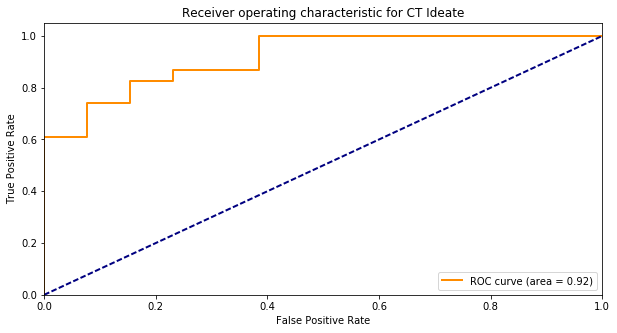

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"Receiver operating characteristic for {entity['title']}")
plt.legend(loc="lower right")
plt.show()

## Automating the annotation process

Now that we have a model with good performance (~.93 AuROC) we can use it to mimick the behaviour of a human annotator. To do so, we'll instanciate the `Annotator` class and call it `Rob v1`, a name to remenber that this is our first model.

In [17]:
from linalgo.annotate import Annotator

In [23]:
annotator = Annotator(name='test_bot', model=text_clf, annotation_type_id=label, threshold=0)

In [50]:
annotator = linalgo_client.create_annotator(annotator={'name': annotator.name, 'model': str(text_clf)})

AttributeError: 'dict' object has no attribute 'annotator_id'

In [51]:
annotator

We're going to use task 46 to test Rob v1.

In [52]:
task = linalgo_client.get_task(46)
annotator.assign_task(task)
print(task)

id: 46
name: Rob v1 - Review
description: Automated annotator (rob v1) review
# documents: 2064
# annotations: 0


Finally, let's use `Rob v1` to annotate all the documents in that task.

In [71]:
annotations, r = [], []
for doc in task.documents:
    annotation = annotator.annotate(doc)
    annotations.append(annotation)
    # Here we save the documents and annotations for quick local visualization
    if annotation.type_id != -1:
        l = "YES"
    else:
        l = "NO"
    r.append({'doc': doc.content, f"{entity['title']}": l, 'score': annotation.score})

In [72]:
annotation.to_json()

{'annotator': 27,
 'data': {'created': '',
  'display_options': {},
  'group': 46,
  'id': 1,
  'permissions': {'delete': ['acct:None@linalgo'],
   'read': ['acct:None@linalgo'],
   'update': ['acct:None@linalgo']},
  'tags': [],
  'target': [{'selector': [], 'source': '/tasks/46/annotate/8237'}],
  'text': '',
  'type_action': 'default',
  'type_flashcard_type': 'default',
  'type_id': 4,
  'type_name': 'UNKNOWN',
  'uri': '/tasks/46/annotate/8237',
  'user': 'acct:None@linalgo'},
 'document': 8237,
 'group': 46,
 'score': 0.9577744941882345,
 'text': 'The main idea being conveyed is that transport plays a huge factor on how the future will turn out. It is a good point that promoting cycling and walking is a better option as vehicles such as car and buses bring about many disadvantages while walking and cycling do not have such a bad impact on the world and the people.',
 'type': 4,
 'uri': '/tasks/46/annotate/8237'}

Let's visualize the newly annotated documents.

In [73]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
d = pd.DataFrame(r)
d.loc[:6, ['doc', 'score', f"{entity['title']}"]]

,doc,score,CT Ideate
0,"The text is about the future of transport in the 21st century and the five opportunities that can leverage transport so that it delivers more inclusive and prosperous cities.\r\n\r\nAccording to the paragraph, the five opportunities are safety, mid-size cities, regional and local leadership, finance, and technology. These five opportunities will ultimately shape the future of transport in the 21st century.\r\n\r\ni concur with the author.",1.053829,YES
1,"The message of the article is to spread awareness of road safety in our cities, greater focus on mid-size cities and make use of data and technology.",0.913531,YES
2,"The author is trying to tell us that with urbanisation, the big cities are just getting bigger, and the small cities are just getting smaller and poorer without the development of finance and national attention, which are all going to the big cities.",1.150839,YES
3,"I think that the message of the text is trying to tell us that transport is a very important factor in the future, where there are cities expected to have 5.2 billion people.",0.948576,YES
4,"This is because in a future where cities can have such a huge amount of people, it is important to have a working and efficient transport system, and some ways the author suggested to improve the transport system is through road safety, mid-sized cities, regional and local governments, finance, and data and technology.",1.046193,YES
5,Who do you think the audience is? Validate your thoughts.,-0.324073,YES
6,"The text is about the transportation of the 21st century, road safety is something that is important and something that we always overlook.Mid-size cities, regional and local leadership, finance, and technology are also importnt opportunites that can leverage transport.These are things that we can all develop on and there are three main enablers that will help cities realize their full potential; Governance, finace and data and technology.",0.885258,YES


If we want to, we can upload the annotations to the LinHub website.

In [78]:
linalgo_client.create_annotations([anno.to_json() for anno in annotations][:10])

<Response [201]>

In [75]:
[anno.to_json() for anno in annotations][4:6]

[{'annotator': 27,
  'data': {'created': '',
   'display_options': {},
   'group': 46,
   'id': 1,
   'permissions': {'delete': ['acct:None@linalgo'],
    'read': ['acct:None@linalgo'],
    'update': ['acct:None@linalgo']},
   'tags': [],
   'target': [{'selector': [], 'source': '/tasks/46/annotate/6178'}],
   'text': '',
   'type_action': 'default',
   'type_flashcard_type': 'default',
   'type_id': 4,
   'type_name': 'UNKNOWN',
   'uri': '/tasks/46/annotate/6178',
   'user': 'acct:None@linalgo'},
  'document': 6178,
  'group': 46,
  'score': 1.0461931429916103,
  'text': 'This is because in a future where cities can have such a huge amount of people, it is important to have a working and efficient transport system, and some ways the author suggested to improve the transport system is through road safety, mid-sized cities, regional and local governments, finance, and data and technology.',
  'type': 4,
  'uri': '/tasks/46/annotate/6178'},
 {'annotator': 27,
  'data': {'created': '',
 

For now we just save the results locally.

In [ ]:
d[['doc', 'score', f"{entity['title']}"]].to_csv(f"{entity['title']}.csv")

## Understanding our models mistakes

Our model is pretty good, but not perfect. We're laways interested in making it better. To that end, it is usually quite informative to look at documents that have been incorrectly annoated by `Rob v1`.

In [ ]:
#TODO: DEMO how to compare manual and Rob's annotations.